### Spark HW2 Moive Recommendation
In this notebook, we will use an Alternating Least Squares (ALS) algorithm with Spark APIs to predict the ratings for the movies in [MovieLens small dataset](https://grouplens.org/datasets/movielens/latest/)
The deadline is 03/10/2019

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

from pyspark.sql.functions import col

In [3]:
import os
os.environ["PYSPARK_PYTHON"] = "python3"

## Part1: Data ETL and Data Exploration

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("moive analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [6]:
movies = spark.read.load("/FileStore/tables/movies.csv", format='csv', header = True)
ratings = spark.read.load("/FileStore/tables/ratings.csv", format='csv', header = True)
links = spark.read.load("/FileStore/tables/links.csv", format='csv', header = True)
tags = spark.read.load("/FileStore/tables/tags.csv", format='csv', header = True)

In [7]:
movies.show(5)

+-------+--------------------+--------------------+
movieId| title| genres|
+-------+--------------------+--------------------+
 1| Toy Story (1995)|Adventure|Animati...|
 2| Jumanji (1995)|Adventure|Childre...|
 3|Grumpier Old Men ...| Comedy|Romance|
 4|Waiting to Exhale...|Comedy|Drama|Romance|
 5|Father of the Bri...| Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows

In [8]:
ratings.show(5)

+------+-------+------+----------+
userId|movieId|rating| timestamp|
+------+-------+------+----------+
 1| 307| 3.5|1256677221|
 1| 481| 3.5|1256677456|
 1| 1091| 1.5|1256677471|
 1| 1257| 4.5|1256677460|
 1| 1449| 4.5|1256677264|
+------+-------+------+----------+
only showing top 5 rows

In [9]:
tmp1 = ratings.groupBy("userID").count().toPandas()['count'].min()
tmp2 = ratings.groupBy("movieId").count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 1
Minimum number of ratings per movie is 1

In [10]:
tmp1 = sum(ratings.groupBy("movieId").count().toPandas()['count'] == 1)
tmp2 = ratings.select('movieId').distinct().count()
print('{} out of {} movies are rated by only one user'.format(tmp1, tmp2))

10155 out of 53889 movies are rated by only one user

## Part 1: Spark SQL and OLAP

### Q1: The number of Users

In [13]:
q1_res = ratings.select('userId').distinct().count()
print('The number of users is {}.'.format(q1_res))

The number of users is 283228.

### Q2: The number of Movies

In [15]:
q2_res = movies.select('movieId').distinct().count()
print('The number of movies is {}.'.format(q2_res))

The number of movies is 58098.

### Q3:  How many movies are rated by users? List movies not rated before

In [17]:
q3_res_1 = ratings.select('movieId').distinct().count()
print('The number of movies have been rated is {}.'.format(q3_res_1))
movies.createOrReplaceTempView('movies')
ratings.createOrReplaceTempView('ratings')
# q3_res_2   .where(ratings.movieId == null)
# t = movies.join(ratings, movies.movieId == ratings.movieId, 'left').orderBy(ratings.movieId)
# t.where(t.movieId == 'null').show()
# t = movies.where(col('movieId').isin(ratings.select('movieId'))).select('movieId')
# t.show()


q3_res_2 = spark.sql(" SELECT movieId, title FROM movies WHERE movieId NOT IN (select movieId from ratings)")
# q3_res_2.rdd.map(lambda x :x).collect()
diaplay(q3_res_2)
# q3_res_2 = spark.sql(" SELECT ratings.movieId FROM ratings")
# q3_res_2.show()


# movies.where(col('movieId').isin(ratings.select('movieId').rdd.flatMap(lambda x: x).collect())).select('movieId').show() .where(ratings.movieId == null)

### Q4: List Movie Genres

In [19]:
Genres = set(movies.select('genres').distinct().rdd.flatMap(lambda x: x).flatMap(lambda x: x.split('|')).collect())
Genres

Out[ 12 ]: 
{'(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

### Q5: Movie for Each Category

In [21]:
d = {}
for genre in Genres:
    d[genre] = movies.where(col('genres').contains(genre)).select('title')

In [22]:
d['Action'].show()

+--------------------+
 title|
+--------------------+
 Heat (1995)|
 Sudden Death (1995)|
 GoldenEye (1995)|
Cutthroat Island ...|
 Money Train (1995)|
 Assassins (1995)|
Dead Presidents (...|
Mortal Kombat (1995)|
Guardian Angel (1...|
Lawnmower Man 2: ...|
From Dusk Till Da...|
 Fair Game (1995)|
 Screamers (1995)|
Crossing Guard, T...|
 White Squall (1996)|
 Nick of Time (1995)|
 Broken Arrow (1996)|
 Shopping (1994)|
 Braveheart (1995)|
Rumble in the Bro...|
+--------------------+
only showing top 20 rows

## Part2: Spark ALS based approach for training model
We will use an RDD-based API from [pyspark.mllib](https://spark.apache.org/docs/2.1.1/mllib-collaborative-filtering.html) to predict the ratings, so let's reload "ratings.csv" using ``sc.textFile`` and then convert it to the form of (user, item, rating) tuples.

### Please refer to Spark ML ALS model
https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/4999972933037924/899848065201823/8135547933712821/latest.html

In [24]:
from pyspark.mllib.recommendation import ALS

In [25]:
movie_rating = sc.textFile("/FileStore/tables/ratings_small.csv")

In [26]:
header = movie_rating.take(1)[0]
rating_data = movie_rating.filter(lambda line: line!=header).map(lambda line: line.split(",")).map(lambda tokens: (tokens[0],tokens[1],tokens[2])).cache()


In [27]:
# check three rows
# rating_data.take(3)

Now we split the data into training/validation/testing sets using a 6/2/2 ratio.

In [29]:
train, validation, test = rating_data.randomSplit([6,2,2],seed = 7856)

In [30]:
train.cache()

Out[ 37 ]: PythonRDD[5673] at RDD at PythonRDD.scala:56

In [31]:
validation.cache()

Out[ 38 ]: PythonRDD[5674] at RDD at PythonRDD.scala:56

In [32]:
test.cache()

Out[ 39 ]: PythonRDD[5675] at RDD at PythonRDD.scala:56

### ALS Model Selection and Evaluation

With the ALS model, we can use a grid search to find the optimal hyperparameters.

In [34]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # write your approach to train ALS model
            als = ALS()
            model = als.train(train_data, rank = rank, iterations= num_iters, lambda_= reg)
            # make prediction
            predect = model.predictAll(validation_data.map(lambda x: (x[0],x[1]))).map(lambda x: ((x[0],x[1]),x[2]))
#             print(predect.collect())
            # get the rating result
            rating = validation_data.map(lambda x: ((int(x[0]), int(x[1])), float(x[2]))).join(predect)
            # get the RMSE
#             print(rating.take(5))
            error = np.sqrt(rating.map(lambda x: (x[1][0] - x[1][1]) ** 2).mean())
            print ('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print ('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [35]:
num_iterations = 5
ranks = [6, 8, 10, 12, 14]
reg_params = [0.05, 0.1, 0.2, 0.4, 0.8]

import time
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

6 latent factors and regularization = 0.05: validation RMSE is 0.9763809484428584
6 latent factors and regularization = 0.1: validation RMSE is 0.9218440465501428
6 latent factors and regularization = 0.2: validation RMSE is 0.8961220733625441
6 latent factors and regularization = 0.4: validation RMSE is 0.9611986221927663
6 latent factors and regularization = 0.8: validation RMSE is 1.18790660935435
8 latent factors and regularization = 0.05: validation RMSE is 1.0016794779084501
8 latent factors and regularization = 0.1: validation RMSE is 0.9179749302862555
8 latent factors and regularization = 0.2: validation RMSE is 0.8982755223060397
8 latent factors and regularization = 0.4: validation RMSE is 0.973575492459692
8 latent factors and regularization = 0.8: validation RMSE is 1.1882872559899376
10 latent factors and regularization = 0.05: validation RMSE is 0.9981640191797291
10 latent factors and regularization = 0.1: validation RMSE is 0.9237578333413019
10 latent factors and regularization = 0.2: validation RMSE is 0.8962773392628628
10 latent factors and regularization = 0.4: validation RMSE is 0.9692262297044901
10 latent factors and regularization = 0.8: validation RMSE is 1.1873258142938672
12 latent factors and regularization = 0.05: validation RMSE is 1.0096388484828
12 latent factors and regularization = 0.1: validation RMSE is 0.9179201508731586
12 latent factors and regularization = 0.2: validation RMSE is 0.8980501979421689
12 latent factors and regularization = 0.4: validation RMSE is 0.9638880614238879
12 latent factors and regularization = 0.8: validation RMSE is 1.1871396884431087
14 latent factors and regularization = 0.05: validation RMSE is 1.012105957215561
14 latent factors and regularization = 0.1: validation RMSE is 0.9235323460977173
14 latent factors and regularization = 0.2: validation RMSE is 0.9008285832889196
14 latent factors and regularization = 0.4: validation RMSE is 0.9661451941446111
14 latent factors and regularization = 0.8: validation RMSE is 1.1874194344262503

The best model has 6 latent factors and regularization = 0.2
Total Runtime: 80.81 seconds

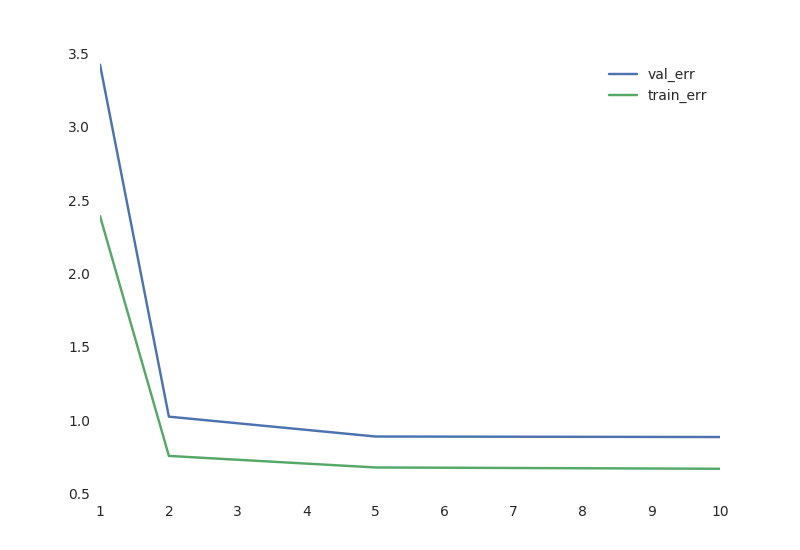

In [36]:
iter_array = [1, 2, 5, 10]

def plot_learning_curve(iter_array, train_data, validation_data, reg, rank):
    val_err = []
    train_err = []
    for iter in iter_array:
        # write your approach to train ALS model
        model = ALS().train(train_data, rank = rank, iterations= iter, lambda_= reg)
        # make prediction
        predect_val = model.predictAll(validation_data.map(lambda x: (x[0],x[1]))).map(lambda x: ((x[0],x[1]),x[2]))
        predect_train = model.predictAll(train_data.map(lambda x: (x[0],x[1]))).map(lambda x: ((x[0],x[1]),x[2]))

        # get the rating result
        rating_val = validation_data.map(lambda x: ((int(x[0]), int(x[1])), float(x[2]))).join(predect_val)
        rating_train = train_data.map(lambda x: ((int(x[0]), int(x[1])), float(x[2]))).join(predect_train)

        # get the RMSE
        error_val = np.sqrt(rating_val.map(lambda x: (x[1][0] - x[1][1]) ** 2).mean())
        error_train = np.sqrt(rating_train.map(lambda x: (x[1][0] - x[1][1]) ** 2).mean())  
        val_err.append(error_val)
        train_err.append(error_train)
    plt.figure()
    plt.plot(iter_array, val_err, label = 'val_err')
    plt.plot(iter_array, train_err, label = 'train_err')
    plt.legend()
    display()
plot_learning_curve(iter_array, train, validation, 0.2, 8)
# write your function to plot the learning curve 

### Model testing on the test data
And finally, wite your code to make a prediction and check the testing error.

In [38]:
model = ALS().train(train, rank = 8, iterations= 10, lambda_= 0.2)
# make prediction
predect_test = model.predictAll(test.map(lambda x: (x[0],x[1]))).map(lambda x: ((x[0],x[1]),x[2]))
rating_test = test.map(lambda x: ((int(x[0]), int(x[1])), float(x[2]))).join(predect_test)
error_test = np.sqrt(rating_test.map(lambda x: (x[1][0] - x[1][1]) ** 2).mean())
print ('\nThe rmase of testinf on best model is {}.'.format(error_test))       

The rmase of testinf on best model is 0.8861542118638658.

In [39]:
model.recommendProductsForUsers(3).collect()

Out[ 44 ]: 
[(512,
 (Rating(user=512, product=170355, rating=5.13408616191327),
 Rating(user=512, product=3379, rating=5.13408616191327),
 Rating(user=512, product=96004, rating=5.13408616191327))),
 (320,
 (Rating(user=320, product=25906, rating=4.677093857005424),
 Rating(user=320, product=77846, rating=4.677093857005424),
 Rating(user=320, product=67618, rating=4.674324480226865))),
 (128,
 (Rating(user=128, product=1046, rating=5.199197678160557),
 Rating(user=128, product=96004, rating=5.19425880825911),
 Rating(user=128, product=3379, rating=5.19425880825911))),
 (64,
 (Rating(user=64, product=170355, rating=5.239922071807351),
 Rating(user=64, product=3379, rating=5.239922071807351),
 Rating(user=64, product=96004, rating=5.239922071807351))),
 (448,
 (Rating(user=448, product=5490, rating=4.712824530933233),
 Rating(user=448, product=132333, rating=4.712824530933233),
 Rating(user=448, product=170355, rating=4.51226147873404))),
 (576,
 (Rating(user=576, product=213, rating=5.363354928688981),
 Rating(user=576, product=89904, rating=4.837196503174094),
 Rating(user=576, product=334, rating=4.734388128824648))),
 (256,
 (Rating(user=256, product=67618, rating=5.565094396900765),
 Rating(user=256, product=25906, rating=5.162968369981245),
 Rating(user=256, product=77846, rating=5.162968369981245))),
 (384,
 (Rating(user=384, product=170355, rating=4.794619784497406),
 Rating(user=384, product=3379, rating=4.794619784497406),
 Rating(user=384, product=96004, rating=4.794619784497406))),
 (192,
 (Rating(user=192, product=7842, rating=5.422607361816476),
 Rating(user=192, product=67618, rating=5.355336443808415),
 Rating(user=192, product=25906, rating=5.351193619626235))),
 (321,
 (Rating(user=321, product=67618, rating=4.813668112742117),
 Rating(user=321, product=7842, rating=4.71037973654922),
 Rating(user=321, product=25906, rating=4.630369752193519))),
 (577,
 (Rating(user=577, product=170355, rating=4.673747781819834),
 Rating(user=577, product=3379, rating=4.673747781819834),
 Rating(user=577, product=96004, rating=4.673747781819834))),
 (193,
 (Rating(user=193, product=26116, rating=4.617235828002634),
 Rating(user=193, product=8235, rating=4.601005497529308),
 Rating(user=193, product=6201, rating=4.601005497529308))),
 (513,
 (Rating(user=513, product=170355, rating=5.05512164668974),
 Rating(user=513, product=3379, rating=5.05512164668974),
 Rating(user=513, product=96004, rating=5.05512164668974))),
 (65,
 (Rating(user=65, product=170355, rating=4.954796796364617),
 Rating(user=65, product=3379, rating=4.954796796364617),
 Rating(user=65, product=96004, rating=4.954796796364617))),
 (449,
 (Rating(user=449, product=6818, rating=4.545087605808314),
 Rating(user=449, product=3266, rating=4.513430393517073),
 Rating(user=449, product=3379, rating=4.507000680407656))),
 (385,
 (Rating(user=385, product=170355, rating=4.6299456772647565),
 Rating(user=385, product=3379, rating=4.6299456772647565),
 Rating(user=385, product=96004, rating=4.6299456772647565))),
 (1,
 (Rating(user=1, product=170355, rating=5.94273923515045),
 Rating(user=1, product=3379, rating=5.94273923515045),
 Rating(user=1, product=96004, rating=5.94273923515045))),
 (257,
 (Rating(user=257, product=86377, rating=4.345683154270327),
 Rating(user=257, product=67618, rating=4.341122154866257),
 Rating(user=257, product=4256, rating=4.323090224976754))),
 (129,
 (Rating(user=129, product=67618, rating=5.184022471956292),
 Rating(user=129, product=3379, rating=5.183795476634393),
 Rating(user=129, product=170355, rating=5.183795476634393))),
 (450,
 (Rating(user=450, product=170355, rating=5.432752979001223),
 Rating(user=450, product=3379, rating=5.432752979001223),
 Rating(user=450, product=96004, rating=5.432752979001223))),
 (386,
 (Rating(user=386, product=5490, rating=4.012084584502437),
 Rating(user=386, product=132333, rating=4.012084584502437),
 Rating(user=386, product=26258, rating=3.9587641152244237))),
 (130,
 (Rating(user=130, product=67

### Conclusion. 
Use four sentences to summary your work. Like what you have done, how to do it, what the techinical steps, what is your business impact. 
More details are appreciated. You can think about this a report for your manager. Then, you need to use this experience to prove that you have strong background on big  data analysis.  
Point 1:  what is your story ? and why you do this work ?   
Point 2:  how can you do it ?  keywords: Spark, Spark SQL, Dataframe, Data clean, Data visulization, Data size, clustering, OLAP,   
Point 3:  what do you learn from the data ?  keywords: crime, trend, advising, conclusion, runtime

### Report

Did Data ETL and Data Exploration on 1GB MovieLens movie rating dataset using Spark SQL and Spark Dataframe.  
Implemented Alternating Least Square (ALS) model using Spark.MLlib to achieve a movie recommendation system.  
Tuned the hyper-parameters of ALS based on Spark RDD and Dataframe and learned the latent factors of users and items.